In [1]:
import json 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from sedpy import observate

from astropy.cosmology import FlatLambdaCDM

In [2]:
# Load in the basic data
df = pd.read_csv("../data/all_basic_data.csv")

# Load in the nebular continuum
df_nebc = pd.read_csv("../data/all_nebc.csv")

In [3]:
# Some constants
ndir = 10 # Number of directions from peeling off

lsun = 3.846e33
cosmo = FlatLambdaCDM(H0=67.31, Om0=0.3175, Tcmb0=2.725)
mpc_to_cm = 3.086e+24
clight = 29979245800. #cm/s

In [4]:
intrinsic_emission_line_list = [
 'H  1 1215.67A sphere',
 'H  1 6562.80A sphere',
 'H  1 4861.32A sphere',
 'H  1 4340.46A sphere',
 'H  1 4101.73A sphere',
 'He 2 1640.41A sphere',
 'He 2 4685.68A sphere',
 'O  1 6300.30A sphere',
 'O  1 6363.78A sphere',
 'O  2 3726.03A sphere',
 'O  2 3728.81A sphere',
 'O 2R 3726.00A sphere',
 'O 2R 3729.00A sphere',
 'O  2 7318.92A sphere',
 'O  2 7319.99A sphere',
 'O  2 7329.67A sphere',
 'O  2 7330.73A sphere',
 'O 2R 7332.00A sphere',
 'O 2R 7323.00A sphere',
 'O  3 1660.81A sphere',
 'O  3 1666.15A sphere',
 'O  3 4363.21A sphere',
 'O 3R 4363.00A sphere',
 'O 3C 4363.00A sphere',
 'O  3 4958.91A sphere',
 'O  3 5006.84A sphere',
 'Ne 3 3868.76A sphere',
 'Ne 3 3967.47A sphere',
 'C  3 1906.68A sphere',
 'C  3 1908.73A sphere',
 'C  4 1548.19A sphere',
 'C  4 1550.78A sphere',
 'N  2 5754.61A sphere',
 'N 2R 5755.00A sphere',
 'N  2 6548.05A sphere',
 'N  2 6583.45A sphere',
 'N 2R 6584.00A sphere',
 'N  3 1748.65A sphere',
 'N  3 1753.99A sphere',
 'N  3 1746.82A sphere',
 'N  3 1752.16A sphere',
 'N  3 1749.67A sphere',
 'S  2 6716.44A sphere',
 'S  2 6730.82A sphere',
 'S  2 4076.35A sphere',
 'S  2 4068.60A sphere',
 'S  3 6312.06A sphere',
 'S  3 9068.62A sphere',
 'S  3 9530.62A sphere',
]

In [5]:
# Print a header
df.head(n=10)

,n_stars,stellar_mass,stellar_metallicity,ionizing_luminosity,f_esc,sfr_10,sfr_100,mvir,rvir,redshift,...,beta_dir_0,beta_dir_1,beta_dir_2,beta_dir_3,beta_dir_4,beta_dir_5,beta_dir_6,beta_dir_7,beta_dir_8,beta_dir_9
0,31967.0,7.149566,-3.606605,53.523165,-3.160291,0.82,0.11,9.234144,0.001932,10.0,...,-1.086384,-1.692291,-1.004144,-1.420937,-1.570547,-0.992456,-1.391860,-1.363853,-2.230089,-2.199188
1,50539.0,7.376480,-3.479361,53.323654,-1.132635,0.68,0.19,9.499563,0.002361,10.0,...,-1.882190,-2.412214,-2.441986,-2.238528,-2.382310,-2.331834,-2.119498,-2.369654,-2.254489,-2.300801
2,23168.0,6.979845,-3.407531,53.094837,-0.745604,0.41,0.08,8.990255,0.001602,10.0,...,-1.258022,-2.479552,-0.961888,-1.965357,-2.557239,-2.483516,-2.605934,-1.323825,-1.796427,-2.619682
3,116572.0,7.656417,-3.282300,53.231276,-0.749191,1.08,0.34,9.695849,0.002751,10.0,...,-2.081971,-2.250657,-2.105408,-2.347603,-2.413777,-2.339631,-2.380582,-2.350257,-2.375575,-2.348835
4,27501.0,7.075446,-3.391552,53.112451,-1.222701,0.39,0.13,8.802573,0.001387,10.0,...,-1.745372,-1.990873,-2.270990,-2.209460,-2.323092,-2.279162,-2.229559,-2.249780,-2.166443,-2.182956
5,58050.0,7.393227,-3.721508,53.333181,-1.201217,0.53,0.27,9.429246,0.002244,10.0,...,-2.227647,-2.281190,-2.318773,-2.485119,-2.443098,-2.552385,-2.302865,-2.221181,-2.347203,-2.245679
6,84158.0,7.565318,-3.404906,53.092078,-0.914752,0.49,0.21,9.576676,0.002510,10.0,...,-2.497105,-2.477572,-2.365671,-2.130728,-2.213023,-2.292978,-2.322977,-2.003201,-2.348975,-2.112178
7,464637.0,8.299081,-2.922688,53.454819,-1.255024,1.03,2.10,10.052344,0.003610,10.0,...,-2.037745,-2.018229,-2.017491,-2.006699,-2.098453,-1.840430,-1.838979,-2.024886,-1.962529,-2.058565
8,61656.0,7.450616,-3.433722,53.528050,-0.919589,1.12,0.28,9.461591,0.002293,10.0,...,-2.351597,-2.427192,-2.347284,-2.464998,-2.411082,-2.423944,-2.160504,-2.449493,-2.548413,-2.370295
9,39661.0,7.159046,-3.200290,53.154344,-5.724312,0.44,0.09,8.991689,0.001598,10.0,...,-0.793015,-0.683868,-0.800922,-0.816506,-0.835248,-1.084289,-0.783138,-1.353928,-1.180640,-1.299099


In [6]:
# Print a header
df_nebc.head(n=10)

,halo_id,redshift,nphot,nebc_1300_int,nebc_1400_int,nebc_1500_int,nebc_1600_int,nebc_1700_int,nebc_1800_int,nebc_1900_int,...,nebc_3727_dir_9,nebc_3869_dir_9,nebc_4102_dir_9,nebc_4341_dir_9,nebc_4363_dir_9,nebc_4861_dir_9,nebc_4959_dir_9,nebc_5008_dir_9,nebc_6563_dir_9,nebc_6583_dir_9
0,146472,6.0,200000,4.092643e+38,5.010900e+38,4.904498e+38,4.528532e+38,4.112986e+38,3.721284e+38,3.396351e+38,...,3.350426e+37,3.206285e+37,2.944981e+37,2.763133e+37,2.769894e+37,2.455927e+37,2.430238e+37,2.388518e+37,1.893665e+37,1.889400e+37
1,997,6.0,200000,2.741736e+38,3.374940e+38,3.302280e+38,3.043083e+38,2.756029e+38,2.487423e+38,2.261204e+38,...,3.208159e+37,3.014290e+37,2.743779e+37,2.529613e+37,2.518741e+37,2.173826e+37,2.127709e+37,2.112894e+37,1.593979e+37,1.592268e+37
2,434940,6.0,200000,5.131000e+38,6.165196e+38,6.053423e+38,5.645671e+38,5.197867e+38,4.774654e+38,4.436808e+38,...,1.666871e+37,1.588071e+37,1.519697e+37,1.432271e+37,1.419055e+37,1.350965e+37,1.323626e+37,1.328153e+37,1.131843e+37,1.115681e+37
3,103496,6.0,200000,2.272225e+38,2.790811e+38,2.731186e+38,2.520574e+38,2.289214e+38,2.075335e+38,1.896653e+38,...,2.486121e+37,2.335146e+37,2.119300e+37,1.960468e+37,1.937163e+37,1.702797e+37,1.658965e+37,1.638424e+37,1.281117e+37,1.272890e+37
4,276391,6.0,200000,4.189232e+38,5.000006e+38,4.878364e+38,4.521445e+38,4.137472e+38,3.777418e+38,3.495267e+38,...,5.324828e+36,5.226936e+36,4.913250e+36,4.520675e+36,4.545148e+36,4.188624e+36,4.126821e+36,4.144904e+36,3.895819e+36,3.901778e+36
5,134527,6.0,200000,4.695923e+38,5.660051e+38,5.525639e+38,5.110784e+38,4.661570e+38,4.241016e+38,3.906139e+38,...,2.377603e+37,2.275413e+37,2.125317e+37,2.005076e+37,1.973421e+37,1.814236e+37,1.796114e+37,1.769620e+37,1.484308e+37,1.489599e+37
6,90951,6.0,200000,3.549923e+38,4.317857e+38,4.237373e+38,3.934409e+38,3.599292e+38,3.283913e+38,3.023926e+38,...,3.011690e+37,2.913463e+37,2.718009e+37,2.569481e+37,2.557762e+37,2.331705e+37,2.280718e+37,2.264935e+37,1.870256e+37,1.850732e+37
7,170147,6.0,200000,7.576110e+38,9.191005e+38,9.002016e+38,8.338571e+38,7.604486e+38,6.903633e+38,6.330199e+38,...,4.397400e+37,4.227321e+37,3.919346e+37,3.699387e+37,3.733867e+37,3.357753e+37,3.286154e+37,3.285919e+37,2.689485e+37,2.688770e+37
8,70397,6.0,200000,6.763254e+39,8.079146e+39,7.800252e+39,7.126806e+39,6.417508e+39,5.763318e+39,5.262870e+39,...,4.189377e+37,4.153809e+37,3.860805e+37,3.718805e+37,3.609522e+37,3.341749e+37,3.271017e+37,3.244305e+37,2.875991e+37,2.901549e+37
9,171111,6.0,200000,4.470129e+38,5.399689e+38,5.301125e+38,4.934889e+38,4.531300e+38,4.151766e+38,3.842361e+38,...,3.499208e+37,3.354786e+37,3.175905e+37,2.997939e+37,2.999070e+37,2.708250e+37,2.686966e+37,2.648171e+37,2.195953e+37,2.165849e+37


In [7]:
def load_throughputs():
    """
    Load the JWST NIRCAM throughputs

    NOTE: we don't use the ones in sedpy because we updated
    the JWST filters with the values in flight
    """
    filt_dir = "/Users/harleykatz/SPHINX20/observational_data/mean_throughputs"

    filter_dict = {
        'F070W': {
            "lam": 0.704,
            "dlam": 0.128,
        },
        'F090W': {
            "lam": 0.901,
            "dlam": 0.194,
        },
        'F115W': {
            "lam": 1.154,
            "dlam": 0.225,
        },
        'F140M': {
            "lam": 1.404,
            "dlam": 0.142
        },
        'F150W': {
            "lam": 1.501,
            "dlam": 0.318,
        },
        'F162M': {
            "lam": 1.626,
            "dlam": 0.168,
        },
        'F182M': {
            "lam": 1.845,
            "dlam": 0.238,
        },
        'F200W': {
            "lam": 1.990,
            "dlam": 0.461,
        },
        'F210M': {
            "lam": 2.093,
            "dlam": 0.205,
        },
        'F250M': {
            "lam": 2.503,
            "dlam": 0.181,
        },
        'F277W': {
            "lam": 2.786,
            "dlam": 0.672,
        },
        'F300M': {
            "lam": 2.996,
            "dlam": 0.318,
        },
        'F335M': {
            "lam": 3.365,
            "dlam": 0.347,
        },
        'F356W': {
            "lam": 3.563,
            "dlam": 0.787,
        },
        'F360M': {
            "lam": 3.621,
            "dlam": 0.372,
        },
        'F410M': {
            "lam": 4.092,
            "dlam": 0.436,
        },
        'F430M': {
            "lam": 4.280,
            "dlam": 0.228,
        },
        'F444W': {
            "lam": 4.421,
            "dlam": 1.024,
        },
        'F460M': {
            "lam": 4.624,
            "dlam": 0.228,
        },
        'F480M': {
            "lam": 4.834,
            "dlam": 0.303,
        },
    }

    #loop over all_filters
    for f in filter_dict.keys():
        filter_name = f.split("_")[0]
        dat = np.loadtxt(f"{filt_dir}/{f}_mean_system_throughput.txt",skiprows=1)
        filt = observate.Filter(filter_name, data=(1e4*dat[:,0], dat[:,1]))
        filter_dict[f]["filt"] = filt

    return filter_dict

In [8]:
# Load in the JWST filters
filter_dict = load_throughputs()
filter_list = [filter_dict[key]["filt"] for key in filter_dict.keys()]
filter_names = list(filter_dict.keys())
lv = [filter_dict[key]["lam"] for key in filter_dict.keys()]
slv = [filter_dict[key]["dlam"] for key in filter_dict.keys()]

In [9]:
continuum_lams = np.array([ 
    1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000, 
    3727, 3869, 4102, 4341, 4363, 4861, 4959, 5008, 6563, 6583
    ])

## Example intrinsic spectrum at z=6

In [10]:
# Load in the stellar spectra
with open(f"../data/stellar_props/stellar_props_z6.json") as f:
    stellar_spectra = json.load(f)

In [11]:
# Load in the nebular spectra
with open(f"../data/nebular_props/tot_nebc_z6.json") as f:
    nebular_spectra = json.load(f)

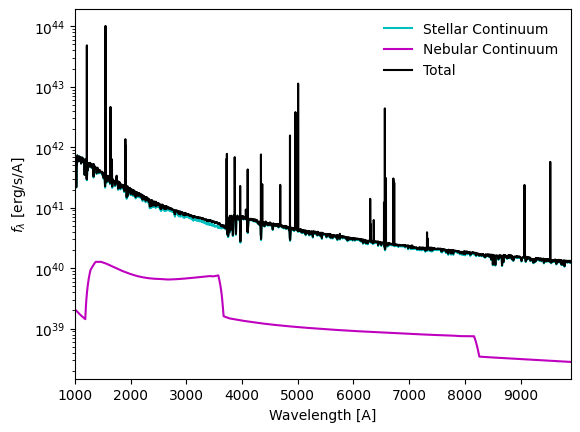

In [13]:
redshift = 6.0
# For a typical galaxy
halo_id = "70405"
# For a nebular continuum dominated galaxy
#halo_id = "415326"
stel_spec = interp1d(stellar_spectra[halo_id]["wave"],np.array(stellar_spectra[halo_id]["spectrum"])*lsun,kind="cubic")
neb_spec  = interp1d(nebular_spectra[halo_id]["wave"],nebular_spectra[halo_id]["spectrum"],kind="linear")

# Set up wavelength grid
lams = np.linspace(1000,9900,8901)
dl = lams[1]-lams[0]

# Plot the intrinsic stellar spectrum
plt.plot(lams,stel_spec(lams),c="c",label="Stellar Continuum")

# Plot the intrinsic nebular continuum
plt.plot(lams,neb_spec(lams),c="m",label="Nebular Continuum")

# Add in the intrinsic emission line luminosities
el_spec = np.zeros(len(lams))
for i in intrinsic_emission_line_list:
    wl = float(i.split()[2].strip("A"))
    idx = np.abs(wl - lams).argmin()
    el_spec[idx] += df[(df["redshift"] == redshift) & (df["halo_id"] == int(halo_id))][i] / dl

# Sum the nebular continuum, stellar continuum, and emission lines
plt.plot(lams,stel_spec(lams)+neb_spec(lams)+el_spec,c="k",label="Total")

plt.yscale("log")
plt.xscale("linear")

plt.xlim(lams[0],lams[-1])

plt.xlabel("Wavelength [A]")
plt.ylabel(r"$f_{\lambda}\ {\rm [erg/s/A]}$")
plt.legend(loc=1,frameon=False)

### Measure the JWST filter magnitudes

In [14]:
# Redshift the spectrum and scale by fesc
loc_lams = lams * (1. + redshift) # --> Redshift the wavelengths
total_spec = (stel_spec(lams) + neb_spec(lams) + el_spec) / (1. + redshift)
total_spec /= (4.0 * np.pi * (cosmo.luminosity_distance(redshift).value*mpc_to_cm)**2) # erg/s/cm^2/A
total_spec_fnu = total_spec * (loc_lams * loc_lams * 1e-8) / clight # erg/s/cm^2/Hz
total_spec[lams <= 1215.67] = 1e-50 # attenuate blueward of Lya
total_spec_fnu[lams <= 1215.67] = 1e-50 # attenuate blueward of Lya
mab_spec = -2.5 * np.log10((total_spec_fnu/1e-23)/3631.)

In [15]:
# Get the AB magnitudes in each Filter
mags = observate.getSED(loc_lams, total_spec, filterlist=filter_list)

Text(0, 0.5, 'AB Magnitude')

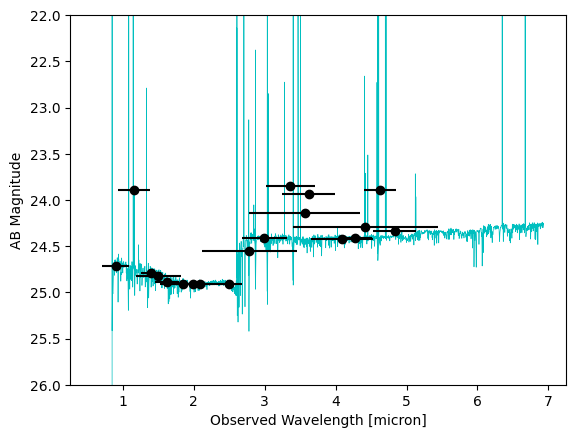

In [16]:
plt.errorbar(lv,mags,xerr=slv,fmt="o",c="k",zorder=20)
plt.plot(loc_lams/1e4,mab_spec,c="c",lw=0.5)
plt.ylim(22,26)
plt.gca().invert_yaxis()
plt.xlabel("Observed Wavelength [micron]")
plt.ylabel("AB Magnitude")

## Example dust attenuated spectrum at z=6

In [17]:
# For now we have only run a subset of emission lines
em_lines = [
'HI_4101.73', 'HI_4340.46', 'HI_4861.32', 'HI_6562.8', 'NeIII_3868.76',
'NII_6583.45', 'OII_3726.03', 'OII_3728.81', 'OIII_4363.21', 'OIII_4958.91',
'OIII_5006.84',
]
em_line_lams = [
    float(key.split("_")[-1]) for key in em_lines
]
continuum_lams = np.array([ 
    1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2500, 3000, 
    3727, 3869, 4102, 4341, 4363, 4861, 4959, 5008, 6563, 6583
    ])

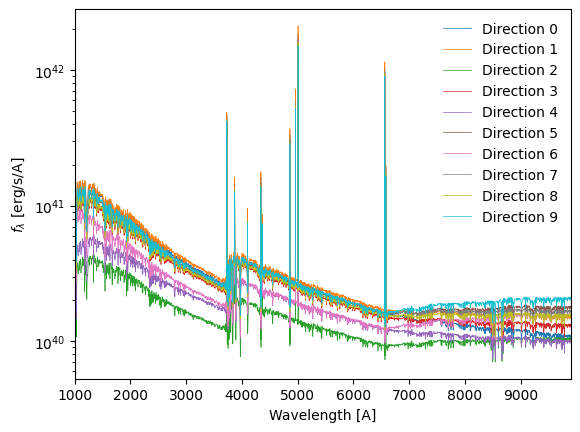

In [18]:
redshift = 6.0
# For a typical galaxy
halo_id = "70405"
# For a nebular continuum dominated galaxy
#halo_id = "415326"
stel_spec = interp1d(stellar_spectra[halo_id]["wave"],np.array(stellar_spectra[halo_id]["spectrum"])*lsun,kind="cubic")
neb_spec  = interp1d(nebular_spectra[halo_id]["wave"],nebular_spectra[halo_id]["spectrum"],kind="linear")

# Get the escape fractions as a function of wavelength
for i in range(10):
    direction = i
    fesc_stellar_l = [ 
        float(df[(df["redshift"] == redshift) & (df["halo_id"] == int(halo_id))][f"cont_{key}_dir_{direction}"] / df[(df["redshift"] == redshift) & (df["halo_id"] == int(halo_id))][f"cont_{key}_int"])
        for key in continuum_lams
    ]
    fesc_nebular_l = [ 
        float(df_nebc[(df_nebc["redshift"] == redshift) & (df_nebc["halo_id"] == int(halo_id))][f"nebc_{key}_dir_{direction}"] / df_nebc[(df_nebc["redshift"] == redshift) & (df_nebc["halo_id"] == int(halo_id))][f"nebc_{key}_int"])
        for key in continuum_lams
    ]

    fesc_interp_stellar = interp1d(continuum_lams,fesc_stellar_l,bounds_error=False,fill_value="extrapolate")
    fesc_interp_nebular = interp1d(continuum_lams,fesc_nebular_l,bounds_error=False,fill_value="extrapolate")

    # Set up wavelength grid
    lams = np.linspace(1000,9900,8901)
    dl = lams[1]-lams[0]

    # Add in the intrinsic emission line luminosities
    el_spec = np.zeros(len(lams))
    for wl,i in zip(em_line_lams,em_lines):
        idx = np.abs(wl - lams).argmin()
        el_spec[idx] += df[(df["redshift"] == redshift) & (df["halo_id"] == int(halo_id))][f"{i}_dir_{direction}"] / dl

    # Sum the nebular continuum, stellar continuum, and emission lines
    plt.plot(
        lams,
        (stel_spec(lams)*fesc_interp_stellar(lams)) + (neb_spec(lams)*fesc_interp_nebular(lams)) + el_spec,
        label=f"Direction {direction}",lw=0.5)

plt.yscale("log")
plt.xscale("linear")

plt.xlim(lams[0],lams[-1])

plt.xlabel("Wavelength [A]")
plt.ylabel(r"$f_{\lambda}\ {\rm [erg/s/A]}$")
plt.legend(loc=1,frameon=False)